# A Brief Introduction to NumPyro
## Presentation for Astro Group 26/2/24

This is a page to accompany a presentation to the UQ astro group on Monday 26/2, outlining some of the features of JAX and NumPyro and briefly explaining the fundamentals of using them. I've intentionally kept as much brief as I can, with more involved walk-throughs detailed in my main [NumPyro Guide](../../02_numpyro/blog_numpyrohome.html).


**Contents**
* [JAX Stuff](#JAX)
* [NumPyro Stuff](#JAX)

---

If you're installing NumPyro for the first time, you'll need kind of linux machine and the following packages:

```
    pip install jax jaxlib jaxopt
    pip install numpyro
```

In these examples, I'm using the pre-updated version of [ChainConsumer](https://samreay.github.io/ChainConsumer/). If you're new to this work and want to go directly from my code snippets, you'll need to install an older version with:

```python
    pip install chainconsumer==0.34.0`
```


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import jax.numpy as jnp  
from jax.random import PRNGKey
import jax
from numpyro import distributions as dist

from chainconsumer import ChainConsumer

## The JAX Part <a id='JAX'></a>
JAX is a [Just-In-Time Compiled](https://en.wikipedia.org/wiki/Just-in-time_compilation) (JIT) language that you can interface with using python. In short: it lets you write python code, but bake into a compiled function at runtime to get a massive speedup. It also has [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (Autodiff) which means it can calculate _analytical_ gradients for any function you write in it.

To show how JIT compilation can give serious speedup for even straightforward problems, I've put together a short example to compare JAX with raw python, as well as the extremely popular [numpy](https://numpy.org/) package. Consider the following: You have a series of optical filters (green, red and infrared bands) for some telescope, and you want to calculate what colour a black body will appear to be at various temperatures.

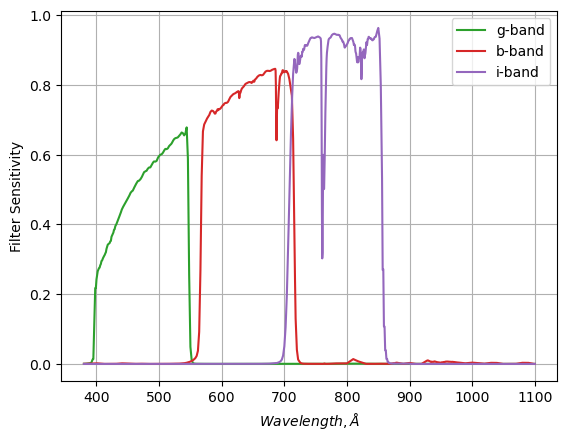

In [2]:
# REDACT
g_fil, r_fil, i_fil = [np.loadtxt("./DES_%s_y3a1.dat"%c, skiprows = 1) for c in ["g","r","i"]]
LAM = g_fil[:,0]
for Y,title,c in zip([g_fil,r_fil,i_fil], ["g-band","b-band","i-band"], ["tab:green","tab:red","tab:purple"]):
    plt.plot(LAM,Y[:,1],label=title,c=c)
plt.grid()
plt.legend()
plt.xlabel("$Wavelength, \AA$")
plt.ylabel("Filter Sensitivity")
plt.show()


The process for doing this is pretty straightforward. We need to integrate the black body spectrum, modulated by the filter strength, for two filters (e.g. red and green) to find the flux we capture in each colour, and then compare the two:

$$
\log_{10} \left( \frac{f_g}{f_r} \right) = \frac{ \int(\lambda f_g(\lambda) \cdot BB(\lambda,T)) d\lambda}{\int(\lambda f_r(\lambda) \cdot BB(\lambda,T)) d\lambda}
$$

Repeating at different temperatures, we can see how the redder low temperature black body spectra compare the the bluer high temperature ones. The particular units aren't too important in this example, so I've replaced "temperature" with "$\beta$", a term inclusive of all the relevant physical constants.

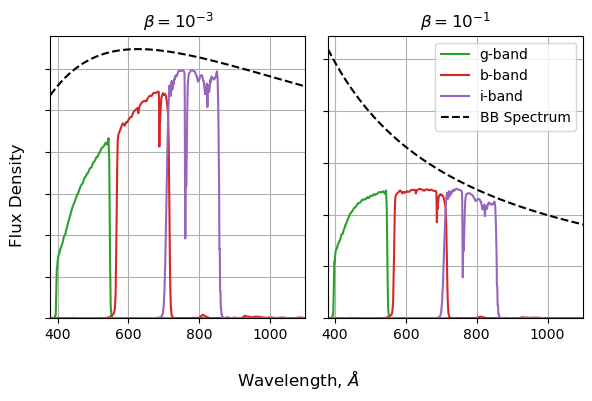

In [7]:
# REDACT
fig, ax = plt.subplots(1,2, sharex=True, figsize=(6,4))

for i,beta in enumerate([0.001, 0.1]):
    bb_spec = 1/LAM**2 * (np.exp(1/LAM/beta)-1)**-1
    for Y,title,c in zip([g_fil,r_fil,i_fil], ["g-band","b-band","i-band"], ["tab:green","tab:red","tab:purple"]):
        ax[i].plot(LAM,Y[:,1]*bb_spec,label=title,c=c)
    ax[i].plot(LAM,bb_spec,c='k',ls='--', label = "BB Spectrum")
    ax[i].grid()
    ax[i].set_yticklabels([])
    ax[i].set_ylim(0)
ax[0].set_title("$ \\beta = 10^{-3} $")
ax[1].set_title("$ \\beta = 10^{-1} $")
fig.supxlabel("Wavelength, $\AA$")
fig.supylabel("Flux Density")
ax[1].legend()
plt.xlim(LAM.min(),LAM.max())
fig.tight_layout()
plt.show()

So, for each temperature, need to:
1. Calculate a BB spectrum with $BB(\lambda,\beta) \propto \lambda^{−1} \exp{\left( \frac{1}{\beta \lambda  }−1 \right)}^{−1}$ 
2. Multiply this by the green filter
3. Integrate over $\lambda$
4. Repeat for the red filter
5. Get the ratio of these integrals
6. Calculate the log

Even if you do this badly, any modern computer can do this in a fraction of a second. To highlight the speed differences, I've cranked the problem up to run for $100,000$ different temperatures, blowing the cost up to a size we can meaningfully examine.

In [3]:
N_temps = 100_000
betas = np.logspace(-2,0,N_temps)

**Doing it with python: The bad way**  
For the sake of comparison, lets first do this with regular python, i.e. using as few packages as possible. Python has no native $\exp(x)$ function, so I've had to dip into `numpy` for that, but everything else here is in the vein of an introductory python tutorial: lots of nested loops and accumulators:

In [31]:
%%time
out_normal = np.zeros(N_temps)
for i in range(N_temps):
    beta = betas[i]
    bb_spec = 1/LAM**2 * (np.exp(1/LAM/beta)-1)**-1
    g_flux = 0
    r_flux = 0
    for j in range(len(LAM)):
        g_flux+=g_fil[:,1][j] * bb_spec[j]
        r_flux+=r_fil[:,1][j] * bb_spec[j]
    out_normal[i] = np.log10(g_flux / r_flux)

CPU times: user 1min 59s, sys: 15 ms, total: 1min 59s
Wall time: 2min 9s


Aside from being a little bit messier to read, raw python is also _slow_. In my benchmark, this takes over two whole minutes, practically an eternity in computer time. There isn't anything fancy in our code that should be particularly costly, this is all about how python handles its loops and calculations. Namely, it handles them poorly.

**Doing it with numpy: the better way**  
If you've spent any time with python, you've probably learned that doing as much as you can with `numpy.array`'s will earn you a much faster code. In our case, swapping the inner loop for `numpy`'s vectorized functions cuts the run-time down by a factor of _sixty_ over base python:

In [32]:
%%time

out_numpy = np.zeros(N_temps)
for i in range(N_temps):
    beta = betas[i]
    bb_spec = 1/LAM**2 * (np.exp(1/LAM/beta)-1)**-1
    g_flux = (g_fil[:,1] * bb_spec).sum()
    r_flux = (r_fil[:,1] * bb_spec).sum()
    out_numpy[i] = np.log10(g_flux / r_flux)

CPU times: user 1.76 s, sys: 8.9 ms, total: 1.77 s
Wall time: 1.91 s


**Doing it with JAX, the fastest way**  
Now we can take a swing at things with JAX. In the snippet below, I first do a bit of house keeping by converting my arrays to JAX-friendly ones, and then define my entire process in a function. You'll notice how similar this is to doing things with `numpy`, the only difference is that I've swapped out the `numpy` math functions (`.np`) functions with `jax.numpy` calls (`jnp.`). These are one-to-one with the familiar `numpy` math functions, but are set up to play nicely with JAX's compilation.

We tell JAX to compile out function into a fast version with `jax.vmap`, specifically "vector mapping" mapping it, i.e. compiling to a form that takes in a vector, even though the function as written is for one number at a time. You can also compile _without_ vector mapping with `jax.jit`. JAX will do the compilation the first time you call the function, so I've run and timed `jax_vectorized_function` twice to show the time with and without the overhead from compiling.

In [11]:
# Convert some arrays to JAX-friendly versions
betas_forjax = jnp.array(betas)
LAM_forjax = jnp.array(LAM)
g_fil_forjax = jnp.array(g_fil[:,1])
r_fil_forjax = jnp.array(r_fil[:,1])

#--------------------------

# Make a function that does all our working with jax.numpy (jnp) instead of numpy (np)
def jax_function(beta):
    bb_spec = np.power(LAM_forjax,-2) * jnp.power((jnp.exp(jnp.power(LAM_forjax*beta,-1))-1),-1)
    g_flux = jnp.sum(g_fil_forjax * bb_spec)
    r_flux = jnp.sum(r_fil_forjax * bb_spec)
    out = jnp.log10(g_flux/r_flux)
    
    return(out)

# Make a "vector mapped" function with jax.vmap
jax_vectorized_function = jax.vmap(jax_function)

# Run and time twice to see with and without compile time
%time out_jax = jax_vectorized_function(betas_forjax)
%time out_jax = jax_vectorized_function(betas_forjax)

CPU times: user 1.51 s, sys: 1.1 s, total: 2.62 s
Wall time: 1 s
CPU times: user 1.48 s, sys: 944 ms, total: 2.43 s
Wall time: 916 ms


**Autodiff**  
As well as the speed it wrings out of its compilation, JAX has a second powerful feature in the form of its auto-differentiation. For any JAX-friendly function (i.e. one we can compile), JAX can also calculate the gradient via the chain rule. In the snippet below, we take `jax_function()` from above, take the derivative with `jax.vmap`, then convert this into a vector-input function with `jax.vmap`. In two lines of code, we get a function that can calculate $df(x)/dx$ as easily as $f(x)$:

In [15]:
# Do auto-differentiation
do_grad = jax.grad(jax_function)

# Do auto-vectorization
do_grad = jax.vmap(do_grad)

For example, suppose we want to plot our log-colour and its gradient side-by side. Thanks to JAX, it's as easy as running our two compiled (fast) functions:

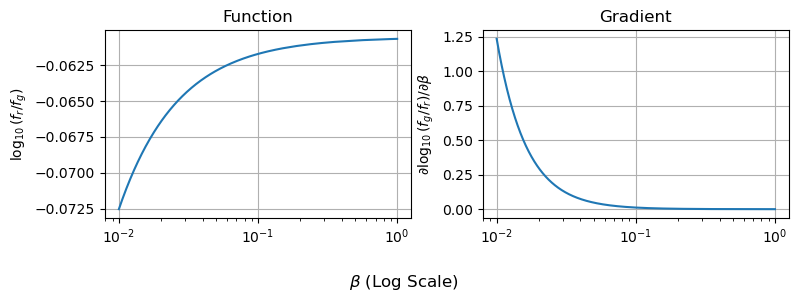

In [17]:
betas_forplot = np.logspace(-2,0,1000)

# Evaluate Function
colours = jax_vectorized_function(betas_forplot)

# Evaluate Gradient Function
grads = do_grad(betas_forplot)

# Plotting
fig, (a1,a2) = plt.subplots(1,2, figsize=(8,3), sharex=True)
a1.plot(betas_forplot, colours), a2.plot(betas_forplot, grads)
a1.grid(), a2.grid()
a1.set_xscale('log')
fig.supxlabel("$\\beta$ (Log Scale)"), 
a1.set_ylabel("$\log_{10} (f_r / f_g)$"), a2.set_ylabel("$\partial \log_{10}(f_g / f_r) / \partial \\beta$")
a1.set_title("Function"), a2.set_title("Gradient")
fig.tight_layout()
plt.show()

We can apply `jax.grad` multiple times over to get higher order derivatives as well. The only caveat is that the way JAX calculates these derivatives means they can lose precision due to computational rounding.
In particular, be aware that JAX's `exp` function isn't very precise when you get to big values. At anything bigger than $\approx exp(10)$, JAX's outputs will begin to get much noiser than comparable `numpy` code, and this only gets worse as you go down the differentiation chain.

## The NumPyro Part <a id='NumPyro'></a>

The following section steps through a few examples of using NumPyro for basic modeling. Firstly, for a simple linear regression, then for a few variations on that theme, and then for a more complex hierarchical model. 

_Note: Much of the following has been lifted directly from the [NumPyro introduction](https://hughmcdougall.github.io/blog/02_numpyro/01_gettingstarted/page.html) on my main [blog](https://hughmcdougall.github.io/blog/02_numpyro/blog_numpyrohome.html)._

### Linear Regression

In this first part we'll look at fitting a simple linear regression to data with Gaussian error bars. I.e., we have a model with parameters $\theta = (m,c)$, and data $(x, y)$, that we believe follows:

$$
    y_i=m \cdot x_i + c \pm \mathcal{N}(0,E_i)
$$

In this example, we enjoy the luxury of already knowing the true underlying model and the true values its parameters (in this case, $m=2$ and $c=3.5$).

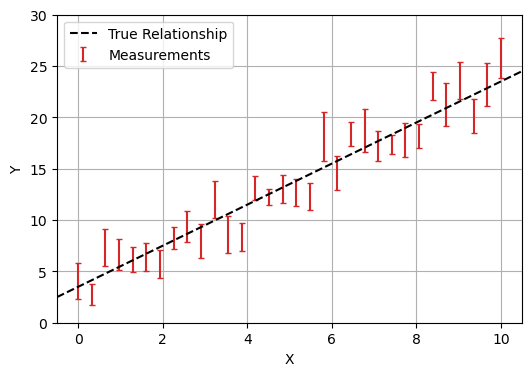

In [20]:
# REDACT
# Model 'truth' parameters  
m_true = 2  
c_true = 3.5
  
#----------------------------  
# Data generation  
ebar, escatter = 1.5, 10 # Average & spread of error bar  
  
np.random.seed(123) # Fix the random seed so results are consistent across different examples  
X = np.linspace(0,10,32)  
E = np.random.poisson(lam=escatter, size=len(X)) / escatter * ebar  
Y = m_true*X + c_true + E*np.random.normal(size=len(X)) # Linear rel /w random noise based on 'E'  
  
#--------------  
# Plotting  
plt.figure(figsize=(6,4))
plt.errorbar(X,Y,E,fmt='none', capsize=2, label='Measurements',c='tab:red')
plt.axline( [0,c_true], slope=m_true, c='k', ls='--', label='True Relationship')  
plt.legend(loc='best')  
plt.xlabel("X"), plt.ylabel("Y")  
plt.ylim(0,30)
plt.grid()  
plt.show()  

**Bayesian Analysis**
NumPyro is an example of a Bayesian analysis tool. The old fashioned way of fitting models is to take your data and then work _backwards_ to your fundamental parameters. Bayesian analyis goes the other way: starting by drawing your parameters from a _prior_ distribution, and then working _forwards_ through a "generative model" to simulate the observations that you would see. You then weight the parameters by how well they reproduce your data (the likelihood).

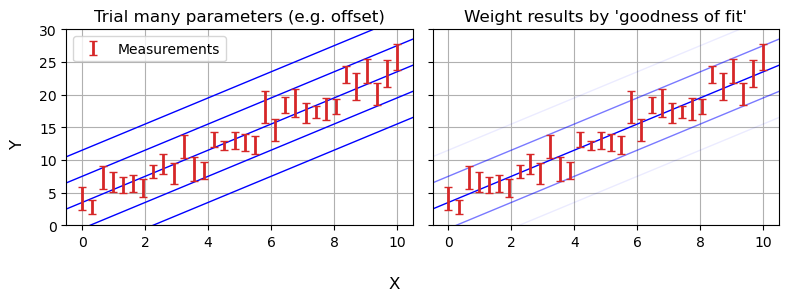

In [24]:
# REDACT

# Plotting  
fig, (a1,a2) = plt.subplots(1, 2, figsize=(8,3), sharex=True, sharey=True)
c_examp = np.linspace(-1,1,5)*8 + c_true
for a in (a1,a2):

    for c in c_examp:

        if a ==a2:
            alpha = np.exp(-((c-c_true)/5)**2)
        else:
            alpha = 1.0

        a.axline( [0,c], slope=m_true, c='blue', ls='-', alpha=alpha,lw=1)
            
    a.errorbar(X,Y,E,fmt='none', capsize=3, label='Measurements',c='tab:red',lw=2)

    a.set_ylim(0,30)
    a.grid()

a1.set_title("Trial many parameters (e.g. offset)")
a2.set_title("Weight results by 'goodness of fit'")
a1.legend()
fig.supxlabel("X"), fig.supylabel("Y")  
fig.tight_layout()
plt.show() 

The purpose of PPL's like NumPyro is that they make the generative model up-front and easy to code / interpret, instead of being abstracted behind test-statistics. Making a NumPyro model that encodes this model is surprisingly simple, and can be done in only a few lines of code:

In [12]:
def model(X,Y,E):  
    m = numpyro.sample("m", numpyro.distributions.Uniform(-5,5))   # prior on m  
    c = numpyro.sample("c", numpyro.distributions.Uniform(-10,10)) # Prior on c  

    # For every data point...
    with numpyro.plate('data', len(X)):  
        y_model = m*X + c  # Get the model value
        numpyro.sample('y', numpyro.distributions.Normal(y_model,E), obs = Y) # Compare to observation

Though written as a python function, `model(X,Y,E)` doesn’t necessarily work like one, e.g. we don’t “return” a likelihood. Instead, each `numpyro.sample` statement implies an effect on the likelihood:

* The first two lines describe our prior knowledge about m and c  
    * The first argument, e.g. "`m`" is the “site name”, the unique name that NumPyro will internally recognize this variable as and return its results as  
    * The python-like variable name `m` on the left hand side is only for using that variable within the function, like we do when we calculate `y_model`  

* The ‘plate’ describes the way we sweep over the data-points in `X` and `Y`  
    * Everything created or called inside the plate is implicitly vectorized where possible, e.g. calling `X` when calculating `y_model` implicitly means `X[i]`
    * The sample `y` follows a normal distribution $y\sim \mathcal{N}(y_{model},E)$, representing our uncorrelated measurements, and the `obs=Y` means that this distribution is being compared to the measurement `Y[i]`
    * The sample `y` doesn’t have a name on the LHS because we don’t use it to do any more calculations

Our NumPyro model encodes all of our probability distributions and data, now we need to actually _do_ something with it. In 90% of cases, that "something" will be constraining parameters with some kind of [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithm. In NumPyro, we do this by creating an `MCMC` object and then triggering it with the `.run` method:

In [13]:
%%time
sampler = numpyro.infer.MCMC(numpyro.infer.NUTS(model),   
                             num_chains  = 1,   
                             num_samples = 10_000,
                             num_warmup  = 5_00)  
sampler.run(jax.random.PRNGKey(1), X,Y,E)  

sample: 100%|█| 10500/10500 [00:04<00:00, 2513.01it/s, 3 steps of size 2.95e


CPU times: user 5.37 s, sys: 94.3 ms, total: 5.46 s
Wall time: 5.87 s


When the `numpyro.infer.MCMC` object is created, we feed it a `numpyro.infer.NUTS` object, which in turn wraps around our probabilistic model. This argument determines what kind of MCMC sampler we use (in this case the No U-Turn Sampler (NUTS)). If you want to use a different sampler (e.g. the [sample adaptive](https://num.pyro.ai/en/latest/mcmc.html#numpyro.infer.sa.SA) sampler), we can swap this first argument out for something else.

Because MCMC is an inherently random process, we need to feed it a random seed to determine how its stochastic elements are generated. This takes the form of the `jax.random.PRNGKey(i)` argument in `sampler.run()`. We also feed in the data (function inputs), `X,Y` and `E` into the sampler when running so it knows what to actually fit the model _on_. Once the sampler has finished running, we just extract its completed MCMC chains using `.get_samples()`, which returns as a dictionary keyed by the NumPyro site names we defined in our model. We can then pass these directly to a `chainconsumer` object for plotting, confirming that our model was fit successfully:

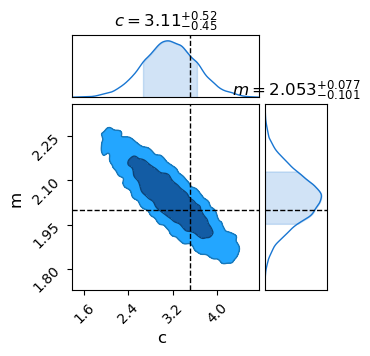

In [14]:
results = sampler.get_samples()
C = ChainConsumer()  
C.add_chain(results, name = "MCMC Results")  
C.plotter.plot(  
    truth = {'m':m_true, 'c':c_true})  
plt.show()  

If you have `graphviz` installed, (e.g. via `conda install -c conda-forge pygraphviz`), NumPyro can automatically render a [graph of the model](https://en.wikipedia.org/wiki/Graphical_model#Bayesian_network) to help visualize it and confirm that everything's set up properly. This is called with:

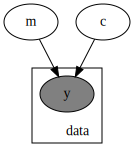

In [15]:
numpyro.render_model(model, model_args=(X,Y,E))

**Reparameterization**  
In the last example we defined our priors over $m$ and $c$, specifically using uniform distributions. It's easy to imagine a case where this might not be the best choice: for example, gradients "thin out" around $m=0$ and "bunch up" as $m \rightarrow \infty$. We might instead want to have a uniform prior over the slope _angle_ and the offset perpendicular to the line, i.e. $m=tan(\theta)$ and $c=b_\perp / cos(\theta)$:

_Note: This example adapted from Dan Foreman Mackey's [Astronomer's Introduction to NumPyro](https://dfm.io/posts/intro-to-numpyro/)_

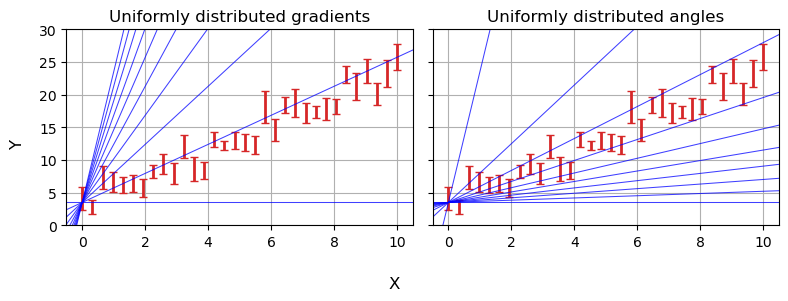

In [30]:
#REDACT
# Plotting  
fig, (a1,a2) = plt.subplots(1, 2, figsize=(8,3), sharex=True, sharey=True)
ms = np.linspace(0,20,10)
angles = np.linspace(0,np.arctan(ms.max()),len(ms))

for a in (a1,a2):
            
    a.errorbar(X,Y,E,fmt='none', capsize=3, label='Measurements',c='tab:red',lw=2)

    a.set_ylim(0,30)
    a.grid()

for m,angle in zip(ms,angles):
    alpha = 0.75
    a1.axline( [0,c_true], slope=m, c='blue', ls='-', alpha=alpha,lw=alpha)
    a2.axline( [0,c_true], slope=np.tan(angle), c='blue', ls='-', alpha=alpha,lw=alpha)

a1.set_title("Uniformly distributed gradients")
a2.set_title("Uniformly distributed angles")

a1.set_ylim(0,30)
fig.supxlabel("X"), fig.supylabel("Y")  
fig.tight_layout()
plt.show() 

With NumPyro, we do this using the `numpyro.deterministic` primitive. This works a lot like sample: the MCMC chains will store `m` and `c` as parameters, but the priors are defined "one level up" rather than `m` and `c` being random variables themselves.

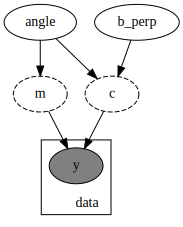

In [17]:
def model_reparam(X,Y,E):
    angle = numpyro.sample('angle', numpyro.distributions.Uniform(-jnp.pi/2,jnp.pi/2))
    b_perp = numpyro.sample('b_perp', numpyro.distributions.Uniform(-5,5))
    
    m = numpyro.deterministic("m", jnp.tan(angle))  
    c = numpyro.deterministic("c", b_perp / jnp.cos(angle)) 
  
    with numpyro.plate('data', len(X)):  
        y_model = m*X + c  
        numpyro.sample('y', numpyro.distributions.Normal(y_model,E), obs = Y)      

#-------------

numpyro.render_model(model_reparam, model_args=(X,Y,E))


Even though they aren't random variables, using:

```python
    m = numpyro.deterministic("m", jnp.tan(angle))
```

Instead of just:

```python
    m = jnp.tan(angle)  
```

Means that NumPyro will keep track of `m` as though it were a parameter during the MCMC process, meaning we can pull it out for analysis, e.g. with a corner plot:

sample: 100%|█| 10500/10500 [00:03<00:00, 3301.92it/s, 7 steps of size 2.47e


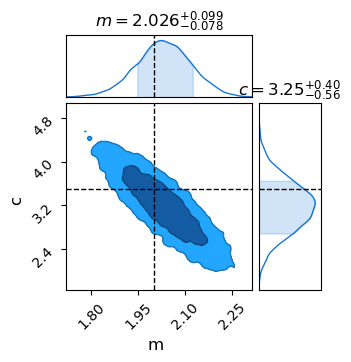

In [18]:
sampler = numpyro.infer.MCMC(numpyro.infer.NUTS(model_reparam), num_chains = 1, num_samples = 10_000, num_warmup = 500)
sampler.run(PRNGKey(1), X, Y, E)
res = sampler.get_samples()
C = ChainConsumer()
C.add_chain(res)
C.plotter.plot(parameters=['m','c'], truth = {'m':m_true, 'c':c_true})
plt.show()

**X-Errors**  
This all might seem like a bit of overkill so far: after all, linear regression is a problem with an analytical solution. It doesn't take much extra complication to make bayesian tools NumPyro necessary: even adding error bars on our $x$ values turns this into a problem with no pen-and-paper answer. Though there are some rough approximations that people use to do this _without_ bayesian modelling (e.g. doing a linear regression with errors in $y$, then again with errors in $x$ and averaging), bayesian tools are the _only_ way to properly handle even this simple case.

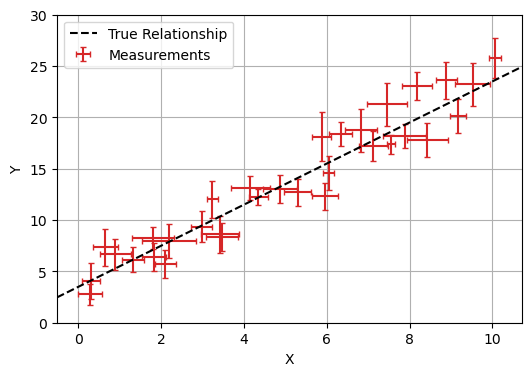

In [19]:
# REDACT
E_X, E_Y = np.sqrt((np.random.randn(len(X))**2 + np.random.randn(len(X))**2))*0.25, E
X_scatter = X + np.random.randn(len(X)) * E_X

plt.figure(figsize=(6,4))
plt.errorbar(X_scatter,Y,yerr=E_Y, xerr=E_X,fmt='none', capsize=2, label='Measurements',c='tab:red')
plt.axline( [0,c_true], slope=m_true, c='k', ls='--', label='True Relationship')  
plt.legend(loc='best')  
plt.xlabel("X"), plt.ylabel("Y")  
plt.ylim(0,30)
plt.grid()  
plt.show()  

#--------------

Fortunately, adding this to our numpyro model is as simple as one extra line. $x$ is now a random / uncertain variable that we observe, so we describe it with a `numpyro.sample` with `obs=X` where `X` is our vector of observed $x$ values:

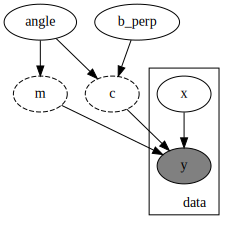

In [20]:
def model_XYerr(X,Y,E_X,E_Y):
    angle = numpyro.sample('angle', numpyro.distributions.Uniform(-jnp.pi/2,jnp.pi/2))
    b_perp = numpyro.sample('b_perp', numpyro.distributions.Uniform(-5,5))
    
    m = numpyro.deterministic("m", jnp.tan(angle))  
    c = numpyro.deterministic("c", b_perp / jnp.cos(angle)) 
  
    with numpyro.plate('data', len(X)):
        x_model = numpyro.sample('x', numpyro.distributions.Normal(X,E_X))
        y_model = m*x_model + c  
        numpyro.sample('y', numpyro.distributions.Normal(y_model,E_Y), obs = Y)

numpyro.render_model(model_XYerr, model_args = (X,Y,E/2, E))

### R-L Hierarchical Example  
The examples so far have been intentionally simple: linear regressions are the kind of thing you could code up by hand if you knew what you were doing. Instead, lets look at a more complicated, though slightly contrived example. The set-up goes like this:

<p style="text-align: center; font-family: verdana"><i>
"Someone spilled a cup of coffee and accidentally deleted every Hertzprung-Russell Diagram on the planet. You need to re-fit it using only some particularly low quality telescope data and some old records of colour temperatures."
</i></p>


The data you have on hand consists of a few dozen clusters of stars with about a half dozen stars per cluster. For the nearest few clusters you have rough parallax measurements, and for every star you have photon-count measurements of brightness, which are subject to [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution) shot noise.

I'm going to make the grievous approximation of pretending that the HR diagram is a straight line in this example, i.e. that absolute magnitudes $M$ obey:

$$
M = \alpha \cdot \log_{10}(T) + \beta \pm \mathcal{N}(0,\sigma)
$$

Where $\alpha$, $\beta$ and $\sigma$ are the slope, offset and inherent scatter of the relation. If you plot the flux-count from each star against its log-temperature, we see that each cluster (colour coded) is roughly a straight line, like we expect, but to get a proper HR diagram we need to vertically shift each cluster until they line up. 

In [31]:
# REDACT 
gain = 5E5
mag0 = 2
E_parallax = 0.025
logtemp0 = 4
min_dist, max_dist = 1, 1000

In [24]:
# REDACT

true_RM = {'slope': -8.0, 'offset':2.0, 'spread':0.5}

def HRmodel(cluster_index, logtemps, parallax = None, fluxcounts = None):
    slope = numpyro.sample('slope', dist.Uniform(-10,0) )
    offset = numpyro.sample('offset', dist.Uniform(-10,10) )
    spread = numpyro.sample('spread', dist.HalfNormal(2.5) ) # HR scatter in magnitudes

    n_clusters = np.unique(cluster_index).size
    n_stars = cluster_index.size

    with numpyro.plate("clusters", n_clusters):
        root_dist = numpyro.sample('root_dist', dist.Uniform(min_dist**(1/3),max_dist**(1/3)) )
        distance = numpyro.deterministic('distance', jnp.power(root_dist,3))
        dist_mod = jnp.log10(distance/10) * 2.5
        
        if parallax is None:
            numpyro.sample('parallax', dist.Normal(jnp.power(distance,-1), E_parallax))
        else:
            numpyro.sample('parallax', dist.Normal(jnp.power(distance,-1), E_parallax), obs=parallax)
        
    with numpyro.plate('stars', n_stars):
        absolute_magnitude = numpyro.sample('absolute_magnitude', dist.Normal((logtemps-logtemp0) * slope + offset,spread))
        apparent_magnitude = numpyro.deterministic('apparent_magnitude',absolute_magnitude + dist_mod[cluster_index])
        flux = jnp.power(10,-(apparent_magnitude-mag0)/2.5) * gain
        
        if fluxcounts is None:
            numpyro.sample('fluxcounts', dist.Poisson(flux))
        else:
            numpyro.sample('fluxcounts', dist.Poisson(flux), obs = fluxcounts)
        

#-----------------------
# Fake Clusters
np.random.seed(2)

num_clusters = 30
cluster_index = np.concatenate([[i] * (j+3) for i,j in enumerate(np.random.poisson(lam=2.0, size=num_clusters))])
cluster_index.sort()
logtemps = np.random.randn(len(cluster_index)) / 6+3.5

mock_data = numpyro.infer.Predictive(model=numpyro.handlers.do(HRmodel, true_RM), num_samples=1)(PRNGKey(2),cluster_index, logtemps)
for key in mock_data.keys():
    if len(mock_data[key].shape)>1: mock_data[key] = mock_data[key][0]

mock_data['parallax'] = np.where(mock_data['parallax']<=E_parallax*2, 0, E_parallax*np.round(mock_data['parallax']/E_parallax))
mock_data |=true_RM

if False:
    fig, (a1,a2) = plt.subplots(1,2)
    
    a1.scatter(logtemps, mock_data['absolute_magnitude'])
    a1.axline( (logtemp0, true_RM['offset']), slope=true_RM['slope'])
    
    a2.scatter(logtemps, np.log10(mock_data['fluxcounts'] * mock_data['distance'][cluster_index]**2 ))
    a2.axline( (np.median(logtemps), np.median(np.log10(mock_data['fluxcounts'] * mock_data['distance'][cluster_index]**2 ))), slope=-true_RM['slope']/2.5)
    a1.invert_yaxis()
    a1.grid(), a2.grid()
    
    plt.figure()
    plt.hist(mock_data['fluxcounts'], bins = 128)
    plt.xscale('log')
    plt.grid()
    plt.show()
    print(mock_data['fluxcounts'][np.argsort(mock_data['fluxcounts'])])

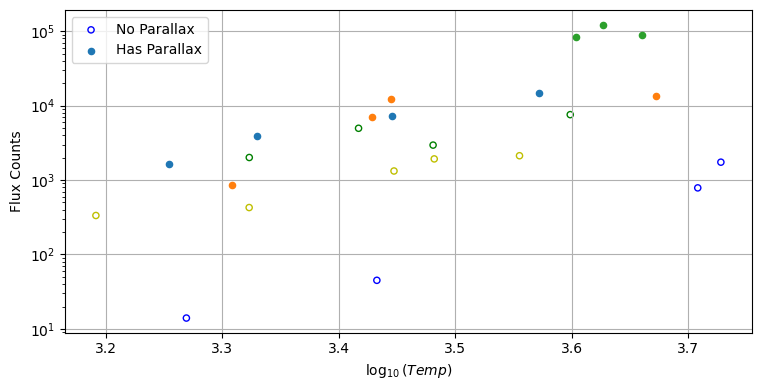

In [25]:
# REDACT
np.random.seed(0)
J = np.random.choice(np.unique(cluster_index), 6, replace=False)

plt.figure(figsize=(8,4))

flag1, flag2 = True, True
for i,j in enumerate(J):
    select = np.argwhere(cluster_index==j)
    if mock_data['parallax'][j] == 0:
        c=None
        edgecolors = np.array(list('rgbcym'*100))[j]
        facecolors= 'none'
        z=-1
        if flag1:
            label = "No Parallax"
            flag1 = False
        else:
            label = None
    else:
        c = None
        facecolors = None
        edgecolors = None
        z = 10
        if flag2:
            label = "Has Parallax"
            flag2 = False
        else:
            label = None

    plt.scatter(logtemps[select], mock_data['fluxcounts'][select], c=c, facecolors=facecolors, edgecolors = edgecolors, label = label, zorder=z, s = 20)
    for k,xk in enumerate(logtemps[select]):
        break
        plt.text(xk, mock_data['fluxcounts'][select][k], "$%i$" %int(mock_data['fluxcounts'][select][k]), fontsize=5)

plt.legend()
plt.xlabel("$\log_{10}(Temp)$")
plt.ylabel("Flux Counts")
plt.grid()
plt.tight_layout()

plt.yscale('log')

If we knew the distances this would be easy: we'd just turn each star's flux into an apparent brightness, get the distance modulus and correct accordingly. The issue is that we're at the mercy of our distance measurements, which fall apart rapidly as we go to bigger distances / smaller parallax angles:

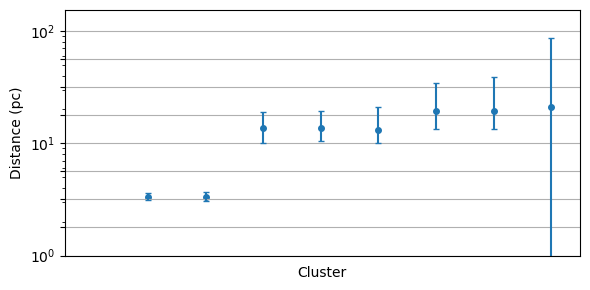

In [67]:
# REDACT
pars = [1/(np.random.randn(2**8) * E_parallax + par) for par in mock_data['parallax']]
dists = np.array([np.median(par) for par in pars])
Emin, Eplus =  np.array([np.percentile(par, 16) for par in pars]),  np.array([np.percentile(par, 84) for par in pars])
Emin = dists - Emin
Eplus= Eplus - dists
I = np.argsort(Eplus)

#------------
plt.figure(figsize=(6,3))
plt.errorbar(range(len(dists)), dists[I], yerr = (Emin[I],Eplus[I]), fmt='none', capsize=2)
plt.scatter(range(len(dists)), dists[I], s=16)


if True:
    plt.yscale('log')
    plt.gca().set_yticks(np.logspace(0,2,9))
else:
    plt.ylim(ymin=0, ymax=45)

plt.xlim(xmax=7.5)
plt.grid()
plt.gca().set_xticks([])
plt.xlabel("Cluster")
plt.ylabel("Distance (pc)")
plt.tight_layout()

plt.show()

Then, couple this with the fact that each cluster has only a few stars. If we were to do this the old fashioned way, we'd have no hope at all of properly constraining the straight line in $\log_{10}(T)$ against $M$. We're also forced to throw away all of the stars that we _don't_ have distances for, leaving us with only a tiny fraction of the data being useful.

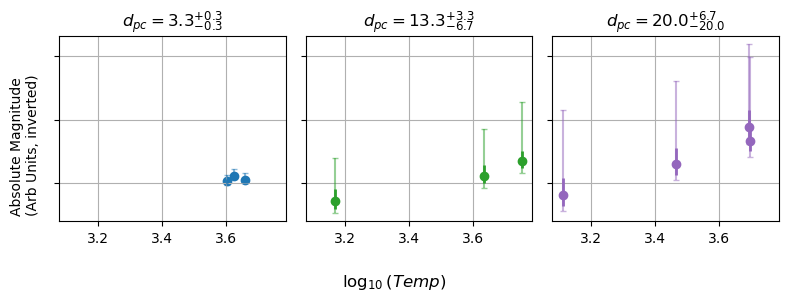

In [66]:
# REDACT
np.random.seed(2)
J = np.random.choice(np.unique(np.argwhere(mock_data['parallax']>0)),3,replace=False)
J = J[np.argsort(mock_data["parallax"][J])[::-1]]

colors = ['tab:blue', 'tab:green', 'tab:purple']
fig, ax = plt.subplots(1,len(J), figsize=(8,3), sharex=True, sharey=True)
for i,j in enumerate(J):
    select = np.argwhere(cluster_index==j)
    #ax[i].scatter(logtemps[select], mock_data['fluxcounts'][select])

    Xplot = logtemps[select]
    Ymean, Yplot, Eplus, Emins, Eplus2sig, Emins2sig = np.zeros(len(Xplot)), np.zeros(len(Xplot)), np.zeros(len(Xplot)), np.zeros(len(Xplot)), np.zeros(len(Xplot)), np.zeros(len(Xplot))
    for k in range(len(Xplot)):
        nreal = 1024

        dists = mock_data["parallax"][j] + np.random.randn(nreal)*E_parallax
        dists = dists * (dists>0)
        dists = 1/(dists+E_parallax*0.1)
        
        fluxes = np.random.randn(nreal) * np.sqrt(mock_data['fluxcounts'][select][k]) + mock_data['fluxcounts'][select][k]
        lums = fluxes *dists**2 * np.pi*4
        Yplot[k] = np.median(lums)
        Ymean[k] = np.mean(lums)
        Emins[k], Eplus[k] = Yplot[k] - np.percentile(lums,16), np.percentile(lums,84) - Yplot[k]
        Emins2sig[k], Eplus2sig[k] = Yplot[k] - np.percentile(lums,5), np.percentile(lums,99.5) - Yplot[k]
    
    ax[i].errorbar(Xplot, Yplot, yerr = (Emins, Eplus), fmt='none', color = colors[i],lw=2)
    ax[i].errorbar(Xplot, Yplot, yerr = (Emins2sig, Eplus2sig), fmt='none', alpha=0.5, capsize=2, color = colors[i])
    
    ax[i].scatter(Xplot, Yplot, color = colors[i])
    #ax[i].scatter(Xplot, Ymean)


    ax[i].set_title("$d_{pc} =  %.1f^{+%.1f}_{-%.1f}$" %(
                    1/mock_data["parallax"][j],
                    1/(mock_data["parallax"][j])-1/(mock_data["parallax"][j] + E_parallax),
                    1/(mock_data["parallax"][j] - E_parallax) - 1/mock_data["parallax"][j]
    ))

    
    ax[i].grid()
    #ax[i].set_ylim(min(mock_data['fluxcounts'][select])/10, mock_data['fluxcounts'][select].min()*100)
    
plt.yscale('log')

fig.supxlabel("$\log_{10}(Temp)$")
fig.supylabel("Absolute Magnitude\n(Arb Units, inverted)", fontsize=10)


plt.gca().set_yticklabels([])
#plt.ylim(ymin=1E8, ymax=1E10)
fig.tight_layout()
plt.show()

The solution is in the form of a [Bayesian Hierarchical Model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling). Though any one cluster / star has a tiny bit of information, the sum total of them gives us more information.

Like always, we start by building a generative model. First, we say that every cluster has a distance, which gives a parallax angle, including uncertainty:

$$
\theta_p = \frac{1}{d_{pc}} \pm \Delta_\theta
$$

Second, that its temperature gives each star an absolute magnitude:

$$
M = \alpha \cdot (\log_{10}(T)-4)+ \beta \pm \mathcal{N}(0,\sigma)
$$

That this converts to an apparent magnitude based on the distance modulus:

$$
m = M + 5.0\times \log_{10} \left(\frac{d}{10 pc}\right)
$$

Which turns into a flux:

$$
f = c \cdot 10^{-(m-m_0) / 2.5}
$$

Which we observe as a photon count, obeying a photon distribution:

$$
N_{flux} \sim Poisson(f)
$$

Despite the number of plates to juggle here, this is pretty easy to code up as a NumPyro model, including all the complexity that we would need to pave-over or approximate with old fashioned "working backwards" methods, e.g. the Poisson distributions and non-gaussian distance errors.

In [70]:
def HRmodel(cluster_index, logtemps, parallax = None, fluxcounts = None):
    slope = numpyro.sample('slope', dist.Uniform(-10,0) )
    offset = numpyro.sample('offset', dist.Uniform(-10,10) )
    spread = numpyro.sample('spread', dist.HalfNormal(2.5) )

    n_clusters = np.unique(cluster_index).size
    n_stars = cluster_index.size

    with numpyro.plate("clusters", n_clusters):
        root_dist = numpyro.sample('root_dist', dist.Uniform(min_dist**(1/3),max_dist**(1/3)) )
        distance = numpyro.deterministic('distance', jnp.power(root_dist,3))
        dist_mod = jnp.log10(distance/10) * 5.0
        
        numpyro.sample('parallax', dist.Normal(jnp.power(distance,-1), E_parallax), obs=parallax)
        
    with numpyro.plate('stars', n_stars):
        absolute_magnitude = numpyro.sample('absolute_magnitude', dist.Normal((logtemps-logtemp0) * slope + offset,spread))
        apparent_magnitude = numpyro.deterministic('apparent_magnitude',absolute_magnitude + dist_mod[cluster_index])
        
        flux = jnp.power(10,-(apparent_magnitude-mag0)/2.5) * gain
        
        numpyro.sample('fluxcounts', dist.Poisson(flux), obs = fluxcounts)
        

In [26]:
# REDACT
hierarchy_sampler = numpyro.infer.MCMC(numpyro.infer.NUTS(HRmodel),
                             num_chains = 1,
                             num_samples = 20_000,
                             num_warmup = 5_000,
                                       progress_bar = False
                            )
hierarchy_sampler.run(rng_key = jax.random.PRNGKey(1), cluster_index = cluster_index, logtemps = logtemps, parallax = mock_data['parallax'], fluxcounts = mock_data['fluxcounts'])

_Note: I've defined the distance prior as being uniform in $d^{1/3}$. This converts to a prior on distance that goes like $P(d)\propto d^2$, which comes from basic geometry._

Because of NumPyro's JAX-like speed, this whole model takes only about 10 minutes on my laptop, and recovers ground truth to within $1 \sigma$:

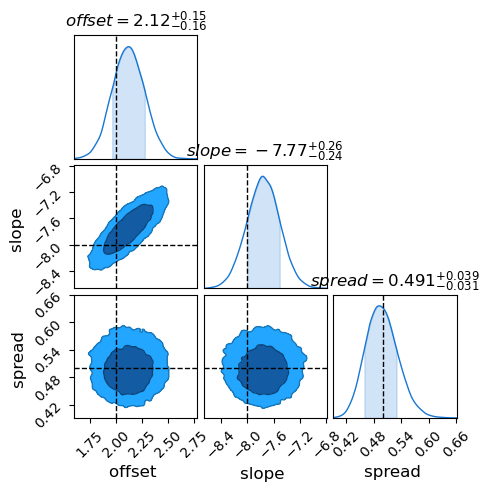

In [74]:
# REDACT
C = ChainConsumer()
res = hierarchy_sampler.get_samples()
res = {key: val for key, val in zip(res.keys(), res.values()) if len(val.shape)==1}
C.add_chain(res)
C.plotter.plot(truth=mock_data)
plt.show()

In [32]:
# REDACT
#numpyro.render_model(HRmodel, model_args=(cluster_index, logtemps, mock_data['parallax'], mock_data['fluxcounts']))

Because this is a mock-up example, we're free to compare our results to the ground truth. Sure enough, once fully converged the model does a remarkably close job of recovering the underlying truth, including the inherent scatter. Through hierachical modeling, we've pulled meaningful information out of patchy data.

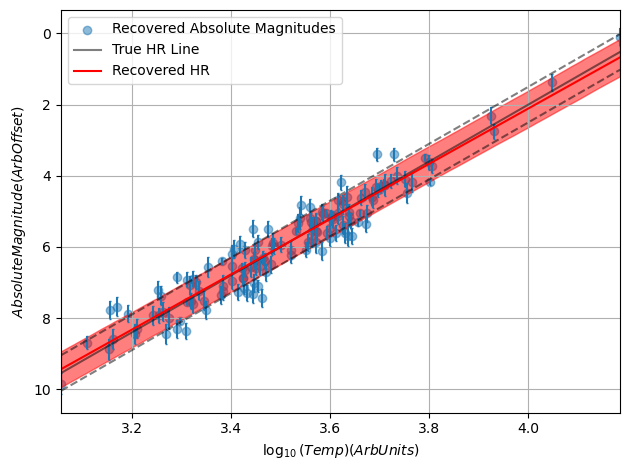

In [76]:
# REDACT
avmags, medmags, low,high = [f(hierarchy_sampler.get_samples()['absolute_magnitude'], axis=0) for f in [np.mean, np.median, lambda x, axis: np.percentile(x,16,axis=axis), lambda x,axis:np.percentile(x,84,axis=axis)]]

# Plot recovered graph
plt.scatter(logtemps, avmags, alpha=0.5, label = "Recovered Absolute Magnitudes")
plt.errorbar(logtemps, medmags, yerr = (medmags-low, high-medmags), fmt='none', capsize=1)

# Plot True Data
plt.axline((logtemp0,mock_data['offset']), slope=mock_data['slope'], c='k', alpha=0.5, label = "True HR Line")
plt.axline((logtemp0,mock_data['offset']+mock_data['spread']), slope=mock_data['slope'], ls='--', c='k', alpha=0.5)
plt.axline((logtemp0,mock_data['offset']-mock_data['spread']), slope=mock_data['slope'], ls='--', c='k', alpha=0.5)

# Do realizations from MCMC samples
X = np.linspace(logtemps.min(),logtemps.max(),128)
outs = np.vstack([(X-logtemp0) * res['slope'][i] + res['offset'][i] + np.random.randn()*res['spread'][i] for i in np.random.randint(0,sampler.num_samples,1_000)])
plt.plot(X, np.mean(outs,axis=0), c='r', label = "Recovered HR")
plt.fill_between(X, np.percentile(outs,16,axis=0), np.percentile(outs,84,axis=0), color='r', alpha=0.5)

# Axis formatting
plt.gca().invert_yaxis()
plt.xlim(X.min(), X.max())
plt.xlabel("$\log_{10}(Temp) (Arb Units)$")
plt.ylabel("$Absolute Magnitude (Arb Offset)$")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

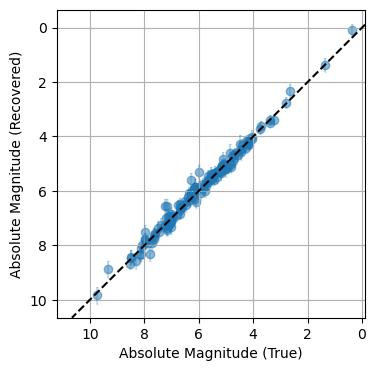

In [80]:
# REDACT
plt.figure(figsize=(4,4))
plt.scatter(mock_data['absolute_magnitude'], avmags, alpha=0.5, lw=1)
plt.errorbar(mock_data['absolute_magnitude'], medmags, yerr = (medmags-low, high-medmags), fmt='none', capsize=1, alpha=0.25)

plt.axis('square')
plt.axline((0,0),slope=1, c='k', ls='--')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel("Absolute Magnitude (True)")
plt.ylabel("Absolute Magnitude (Recovered)")

plt.grid()